In [ ]:
pip install yfinance tensorflow pandas numpy matplotlib seaborn scikit-learn gym stable-baselines3

=== NIFTY50 RL Trading System ===

1. Collecting NIFTY50 data...
Successfully collected data for 30 stocks
Primary stock for analysis: RELIANCE.NS

2. Training RL Agent...
Training PPO agent...
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 897  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.24e+03    |
|    ep_rew_mean          | -1.03       |
| time/                   |             |
|    fps                  | 818         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012340635 |
|    clip_fraction        | 0.127       

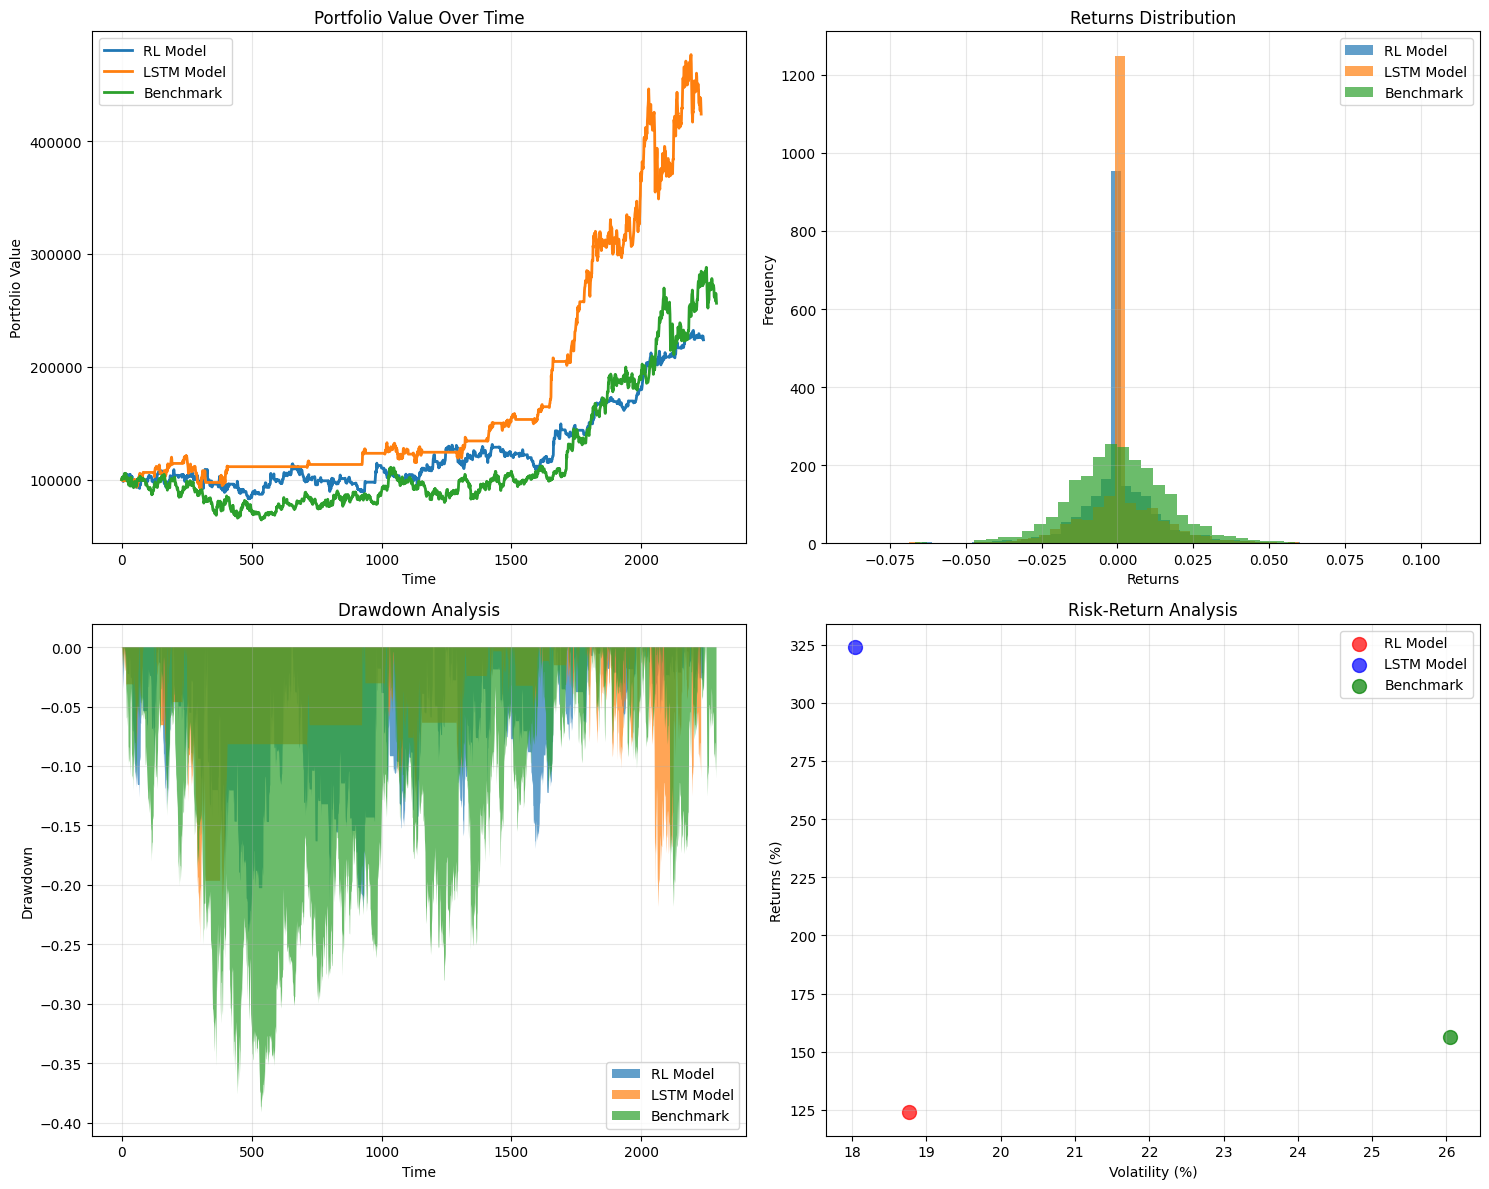


=== DETAILED ANALYSIS ===

Risk-Adjusted Performance:
RL Sharpe Ratio: 0.2395
LSTM Sharpe Ratio: 0.7056
Benchmark Sharpe Ratio: 0.2271

Maximum Drawdown:
RL Max Drawdown: -23.99%
LSTM Max Drawdown: -24.92%
Benchmark Max Drawdown: -39.15%

Final Portfolio Values:
RL Portfolio: $223,883.53
LSTM Portfolio: $423,932.00
Benchmark Portfolio: $256,300.27

=== DETAILED TRADING ANALYSIS FOR RELIANCE.NS ===

Monthly Return Statistics:

RL Model:
  Average Monthly Return: 0.90%
  Monthly Volatility: 5.01%
  Best Month: 15.16%
  Worst Month: -10.47%
  Positive Months: 53/106

LSTM Model:
  Average Monthly Return: 1.50%
  Monthly Volatility: 4.98%
  Best Month: 21.75%
  Worst Month: -10.30%
  Positive Months: 39/106

Benchmark:
  Average Monthly Return: 1.08%
  Monthly Volatility: 6.54%
  Best Month: 24.82%
  Worst Month: -19.07%
  Positive Months: 61/109

Strategy Correlation Matrix:
              RL   LSTM  Benchmark
RL         1.000  0.028      0.016
LSTM       0.028  1.000     -0.013
Benchmark

In [ ]:
# Complete RL Trading System for NIFTY50 Stocks
# Requirements: pip install yfinance tensorflow pandas numpy matplotlib seaborn scikit-learn gymnasium stable-baselines3 shimmy

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Deep Learning and RL imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# RL Environment - Updated for Gymnasium compatibility
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO, A2C, DQN
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import EvalCallback

# Performance Analysis
from scipy import stats
import itertools

# ==================== 1. DATA COLLECTION ====================

class NIFTY50DataCollector:
    def __init__(self):
        # NIFTY 50 stock symbols (major ones for demonstration)
        self.nifty50_symbols = [
            'RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'INFY.NS', 'HINDUNILVR.NS',
            'ICICIBANK.NS', 'SBIN.NS', 'BHARTIARTL.NS', 'ITC.NS', 'ASIANPAINT.NS',
            'KOTAKBANK.NS', 'LT.NS', 'AXISBANK.NS', 'MARUTI.NS', 'SUNPHARMA.NS',
            'TITAN.NS', 'ULTRACEMCO.NS', 'NESTLEIND.NS', 'WIPRO.NS', 'M&M.NS',
            'BAJFINANCE.NS', 'TECHM.NS', 'HCLTECH.NS', 'POWERGRID.NS', 'NTPC.NS',
            'TATAMOTORS.NS', 'BAJAJFINSV.NS', 'GRASIM.NS', 'ADANIENT.NS', 'HINDALCO.NS'
        ]

    def collect_data(self, start_date='2010-01-01', end_date='2019-06-30'):
        """Collect historical data for NIFTY50 stocks"""
        print("Collecting NIFTY50 stock data...")
        stock_data = {}

        for symbol in self.nifty50_symbols:
            try:
                print(f"Downloading {symbol}...")
                ticker = yf.Ticker(symbol)
                data = ticker.history(start=start_date, end=end_date)

                if not data.empty:
                    # Calculate technical indicators
                    data['Returns'] = data['Close'].pct_change()
                    data['MA_5'] = data['Close'].rolling(window=5).mean()
                    data['MA_20'] = data['Close'].rolling(window=20).mean()
                    data['MA_50'] = data['Close'].rolling(window=50).mean()
                    data['RSI'] = self.calculate_rsi(data['Close'])
                    data['MACD'], data['MACD_Signal'] = self.calculate_macd(data['Close'])
                    data['Volatility'] = data['Returns'].rolling(window=20).std()
                    data['BB_Upper'], data['BB_Lower'] = self.calculate_bollinger_bands(data['Close'])

                    stock_data[symbol] = data.dropna()

            except Exception as e:
                print(f"Error downloading {symbol}: {e}")
                continue

        print(f"Successfully collected data for {len(stock_data)} stocks")
        return stock_data

    def calculate_rsi(self, prices, window=14):
        """Calculate Relative Strength Index"""
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    def calculate_macd(self, prices, fast=12, slow=26, signal=9):
        """Calculate MACD"""
        exp1 = prices.ewm(span=fast).mean()
        exp2 = prices.ewm(span=slow).mean()
        macd = exp1 - exp2
        macd_signal = macd.ewm(span=signal).mean()
        return macd, macd_signal

    def calculate_bollinger_bands(self, prices, window=20, num_std=2):
        """Calculate Bollinger Bands"""
        ma = prices.rolling(window=window).mean()
        std = prices.rolling(window=window).std()
        bb_upper = ma + (std * num_std)
        bb_lower = ma - (std * num_std)
        return bb_upper, bb_lower

# ==================== 2. STATE REPRESENTATION ====================

class StateRepresentation:
    def __init__(self, lookback_window=20):
        self.lookback_window = lookback_window
        self.scaler = MinMaxScaler()

    def create_state_features(self, data, current_idx):
        """Create comprehensive state representation"""
        if current_idx < self.lookback_window:
            return None

        # Price-based features
        prices = data['Close'].iloc[current_idx-self.lookback_window:current_idx].values
        returns = data['Returns'].iloc[current_idx-self.lookback_window:current_idx].values
        volumes = data['Volume'].iloc[current_idx-self.lookback_window:current_idx].values

        # Technical indicators
        rsi = data['RSI'].iloc[current_idx-5:current_idx].values
        macd = data['MACD'].iloc[current_idx-5:current_idx].values
        volatility = data['Volatility'].iloc[current_idx-5:current_idx].values

        # Moving averages
        ma_5 = data['MA_5'].iloc[current_idx]
        ma_20 = data['MA_20'].iloc[current_idx]
        ma_50 = data['MA_50'].iloc[current_idx]
        current_price = data['Close'].iloc[current_idx]

        # Relative position indicators
        price_to_ma5 = current_price / ma_5 if ma_5 != 0 else 1
        price_to_ma20 = current_price / ma_20 if ma_20 != 0 else 1
        price_to_ma50 = current_price / ma_50 if ma_50 != 0 else 1

        # Bollinger Bands position
        bb_upper = data['BB_Upper'].iloc[current_idx]
        bb_lower = data['BB_Lower'].iloc[current_idx]
        bb_position = (current_price - bb_lower) / (bb_upper - bb_lower) if (bb_upper - bb_lower) != 0 else 0.5

        # Market momentum
        short_momentum = np.mean(returns[-5:]) if len(returns) >= 5 else 0
        long_momentum = np.mean(returns[-10:]) if len(returns) >= 10 else 0

        # Volume indicators
        volume_ma = np.mean(volumes[-10:]) if len(volumes) >= 10 else volumes[-1]
        volume_ratio = volumes[-1] / volume_ma if volume_ma != 0 else 1

        # Combine all features
        state = np.concatenate([
            [price_to_ma5, price_to_ma20, price_to_ma50],
            [bb_position],
            rsi[-3:] if len(rsi) >= 3 else [50, 50, 50],
            [short_momentum, long_momentum],
            [volume_ratio],
            volatility[-3:] if len(volatility) >= 3 else [0.02, 0.02, 0.02],
            returns[-5:] if len(returns) >= 5 else [0]*5
        ])

        return state

# ==================== 3. ACTION SPACE ====================

class ActionSpace:
    def __init__(self):
        # Action space: 0=Hold, 1=Buy, 2=Sell
        # For continuous actions: [position_change, position_size]
        self.discrete_actions = 3
        self.action_meanings = {0: 'Hold', 1: 'Buy', 2: 'Sell'}

    def get_action_space(self, action_type='discrete'):
        """Define action space"""
        if action_type == 'discrete':
            return spaces.Discrete(self.discrete_actions)
        else:
            # Continuous action space: [position_change (-1 to 1), size (0 to 1)]
            return spaces.Box(low=np.array([-1, 0]), high=np.array([1, 1]), dtype=np.float32)

# ==================== 4. REWARD FUNCTION ====================

class RewardFunction:
    def __init__(self, risk_free_rate=0.05):
        self.risk_free_rate = risk_free_rate / 252  # Daily risk-free rate

    def calculate_reward(self, action, price_change, current_position, transaction_cost=0.001):
        """
        Calculate reward based on:
        - Raw return
        - Risk-adjusted return
        - Transaction costs
        - Position consistency
        """
        # Base return reward
        if action == 1 and current_position >= 0:  # Buy signal
            base_reward = price_change
        elif action == 2 and current_position <= 0:  # Sell signal
            base_reward = -price_change
        elif action == 0:  # Hold
            base_reward = current_position * price_change
        else:
            base_reward = 0

        # Transaction cost penalty
        transaction_penalty = 0
        if action != 0:  # Any action other than hold
            transaction_penalty = -transaction_cost

        # Risk penalty for excessive volatility
        risk_penalty = -abs(price_change) * 0.1 if abs(price_change) > 0.05 else 0

        # Total reward
        total_reward = base_reward + transaction_penalty + risk_penalty

        return total_reward

# ==================== 5. RL TRADING ENVIRONMENT ====================

class TradingEnvironment(gym.Env):
    def __init__(self, stock_data, initial_capital=100000, max_position=1.0):
        super(TradingEnvironment, self).__init__()

        self.stock_data = stock_data
        self.stock_symbols = list(stock_data.keys())
        self.initial_capital = initial_capital
        self.max_position = max_position

        # Initialize state and reward components
        self.state_rep = StateRepresentation()
        self.reward_func = RewardFunction()

        # Action space: 0=Hold, 1=Buy, 2=Sell for each stock
        self.action_space = spaces.Discrete(3)

        # Observation space - Updated for Gymnasium
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(20,), dtype=np.float32
        )

        # Add render_mode for Gymnasium compatibility
        self.render_mode = None

        self.reset()

    def reset(self, seed=None, options=None):
        """Reset environment to initial state - Updated for Gymnasium API"""
        # Handle seed for reproducibility
        if seed is not None:
            np.random.seed(seed)

        self.current_step = 50  # Start after enough data for indicators
        self.current_stock_idx = 0
        self.current_stock = self.stock_symbols[self.current_stock_idx]

        self.portfolio_value = self.initial_capital
        self.cash = self.initial_capital
        self.position = 0  # Current position (-1 to 1)
        self.shares_held = 0

        self.trade_history = []
        self.portfolio_history = [self.initial_capital]

        observation = self._get_observation()
        info = {}

        return observation, info  # Gymnasium returns tuple

    def _get_observation(self):
        """Get current state observation"""
        current_data = self.stock_data[self.current_stock]

        if self.current_step >= len(current_data):
            self.current_step = 50
            self.current_stock_idx = (self.current_stock_idx + 1) % len(self.stock_symbols)
            self.current_stock = self.stock_symbols[self.current_stock_idx]
            current_data = self.stock_data[self.current_stock]

        state = self.state_rep.create_state_features(current_data, self.current_step)

        if state is None:
            state = np.zeros(20)

        # Add portfolio information to state
        portfolio_info = np.array([
            self.position,
            self.cash / self.initial_capital,
            self.portfolio_value / self.initial_capital
        ])

        # Ensure state has correct shape
        if len(state) > 17:
            state = state[:17]
        elif len(state) < 17:
            state = np.pad(state, (0, 17 - len(state)), 'constant')

        full_state = np.concatenate([state, portfolio_info])
        return full_state.astype(np.float32)

    def step(self, action):
        """Execute trading action - Updated for Gymnasium API"""
        current_data = self.stock_data[self.current_stock]

        if self.current_step >= len(current_data) - 1:
            observation = self._get_observation()
            return observation, 0, True, False, {}  # Gymnasium format: obs, reward, terminated, truncated, info

        current_price = current_data['Close'].iloc[self.current_step]
        next_price = current_data['Close'].iloc[self.current_step + 1]
        price_change = (next_price - current_price) / current_price

        # Execute action
        reward = self._execute_trade(action, current_price, next_price, price_change)

        # Update step
        self.current_step += 1

        # Check if episode is done
        terminated = (self.current_step >= len(current_data) - 1) or (self.portfolio_value <= 0)
        truncated = False  # For time limits or other truncation reasons

        # Update portfolio value
        if self.shares_held > 0:
            self.portfolio_value = self.cash + (self.shares_held * next_price)
        else:
            self.portfolio_value = self.cash

        self.portfolio_history.append(self.portfolio_value)

        info = {
            'portfolio_value': self.portfolio_value,
            'position': self.position,
            'current_price': next_price,
            'action': action
        }

        observation = self._get_observation()

        return observation, reward, terminated, truncated, info

    def _execute_trade(self, action, current_price, next_price, price_change):
        """Execute the trading action and calculate reward"""
        reward = 0

        if action == 1:  # Buy
            if self.cash >= current_price and self.position < self.max_position:
                shares_to_buy = min(int(self.cash / current_price),
                                  int((self.max_position - self.position) * self.initial_capital / current_price))
                if shares_to_buy > 0:
                    self.shares_held += shares_to_buy
                    self.cash -= shares_to_buy * current_price * 1.001  # Include transaction cost
                    self.position = min(self.max_position,
                                      self.shares_held * current_price / self.initial_capital)

                    self.trade_history.append({
                        'step': self.current_step,
                        'action': 'Buy',
                        'price': current_price,
                        'shares': shares_to_buy
                    })

        elif action == 2:  # Sell
            if self.shares_held > 0:
                shares_to_sell = self.shares_held
                self.cash += shares_to_sell * current_price * 0.999  # Include transaction cost
                self.shares_held = 0
                self.position = 0

                self.trade_history.append({
                    'step': self.current_step,
                    'action': 'Sell',
                    'price': current_price,
                    'shares': shares_to_sell
                })

        # Calculate reward
        reward = self.reward_func.calculate_reward(action, price_change, self.position)

        return reward

# ==================== 6. LSTM BENCHMARK MODEL ====================

from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping

class LSTMTradingModel:
    def __init__(self, sequence_length=60, features=5):
        self.sequence_length = sequence_length
        self.features = features
        self.scaler = MinMaxScaler()
        self.model = None

    def prepare_lstm_data(self, stock_data, symbol, train_ratio=0.8):
        data = stock_data[symbol].copy()
        feature_columns = ['Close', 'Volume', 'MA_20', 'RSI', 'MACD']
        feats = data[feature_columns].values

        # --- fit on TRAIN only to avoid leakage ---
        split_idx = int(len(feats) * train_ratio)

        self.scaler = MinMaxScaler()
        feats_train = self.scaler.fit_transform(feats[:split_idx])
        feats_test  = self.scaler.transform(feats[split_idx:])

        def make_xy(arr, start_idx):
            X, y = [], []
            for i in range(self.sequence_length, len(arr)):
                X.append(arr[i-self.sequence_length:i])
                ret = (data['Close'].iloc[start_idx + i] - data['Close'].iloc[start_idx + i - 1]) / data['Close'].iloc[start_idx + i - 1]
                y.append(1 if ret > 0 else 0)
            return np.array(X), np.array(y)

        X_train, y_train = make_xy(feats_train, 0)
        X_test,  y_test  = make_xy(feats_test, split_idx)
        return X_train, y_train, X_test, y_test

    def build_lstm_model(self):
        model = Sequential([
            LSTM(64, return_sequences=True, input_shape=(self.sequence_length, self.features)),
            Dropout(0.2),
            LSTM(64),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
        return model

    def train_lstm(self, X_train, y_train, X_val, y_val, epochs=50, batch_size=64):
        self.model = self.build_lstm_model()
        # --- class weights to fight imbalance & push probabilities away from 0.5 ---
        classes = np.array([0,1])
        cw = compute_class_weight('balanced', classes=classes, y=y_train)
        class_weight = {0: cw[0], 1: cw[1]}

        es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            class_weight=class_weight,
            callbacks=[es],
            verbose=1
        )
        return history

    def predict(self, X):
        if self.model is None:
            raise ValueError("Model not trained yet")
        return self.model.predict(X).ravel()  # <- flatten to 1D

    def lstm_trading_strategy(self, stock_data, symbol, buy_q=0.6, sell_q=0.4, cooldown=5):
      # Predict on the WHOLE series using the already-fitted scaler
      data = stock_data[symbol].copy()
      feature_columns = ['Close', 'Volume', 'MA_20', 'RSI', 'MACD']
      feats = self.scaler.transform(data[feature_columns].values)  # use fitted scaler

      X = []
      for i in range(self.sequence_length, len(feats)):
          X.append(feats[i-self.sequence_length:i])
      X = np.array(X)
      if len(X) == 0:
          return []

      probs = self.predict(X)  # shape (N,)

      # --- adaptive cutoffs: pick actions by percentile so you don't sit at 0.5 forever ---
      hi = np.quantile(probs, buy_q)   # e.g., top 40% buys
      lo = np.quantile(probs, sell_q)  # e.g., bottom 40% sells

      # hysteresis to avoid flip-flop + cooldown after a trade
      signals = []
      position = 0      # 0 flat, 1 long (we only do long in your sim)
      cool = 0
      for p in probs:
          if cool > 0:
              signals.append(0)
              cool -= 1
              continue
          if position == 0 and p >= hi:
              signals.append(1)  # buy
              position = 1
              cool = cooldown
          elif position == 1 and p <= lo:
              signals.append(2)  # sell
              position = 0
              cool = cooldown
          else:
              signals.append(0)  # hold
      return signals


# ==================== 7. RL AGENT TRAINING ====================

class RLTrader:
    def __init__(self, stock_data):
        self.stock_data = stock_data
        self.env = TradingEnvironment(stock_data)
        self.models = {}

    def train_rl_agent(self, algorithm='PPO', total_timesteps=100000):
        """Train RL agent using specified algorithm"""
        print(f"Training {algorithm} agent...")

        if algorithm == 'PPO':
            model = PPO('MlpPolicy', self.env, verbose=1,
                       learning_rate=0.0003, n_steps=2048, batch_size=64)
        elif algorithm == 'A2C':
            model = A2C('MlpPolicy', self.env, verbose=1, learning_rate=0.0007)
        elif algorithm == 'DQN':
            model = DQN('MlpPolicy', self.env, verbose=1, learning_rate=0.0001)
        else:
            raise ValueError(f"Unsupported algorithm: {algorithm}")

        # Train the model
        model.learn(total_timesteps=total_timesteps)

        self.models[algorithm] = model
        return model

    def evaluate_rl_agent(self, model, num_episodes=10):
        """Evaluate trained RL agent - Updated for Gymnasium"""
        total_rewards = []
        portfolio_values = []

        for episode in range(num_episodes):
            obs, info = self.env.reset()  # Gymnasium returns tuple
            episode_reward = 0
            terminated = False
            truncated = False

            while not (terminated or truncated):
                action, _ = model.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, info = self.env.step(action)
                episode_reward += reward

            total_rewards.append(episode_reward)
            portfolio_values.append(info.get('portfolio_value', self.env.initial_capital))

        return {
            'mean_reward': np.mean(total_rewards),
            'std_reward': np.std(total_rewards),
            'mean_portfolio_value': np.mean(portfolio_values),
            'mean_return': (np.mean(portfolio_values) - self.env.initial_capital) / self.env.initial_capital
        }

# ==================== 8. PERFORMANCE ANALYSIS ====================

class PerformanceAnalyzer:
    def __init__(self):
        pass

    def calculate_metrics(self, returns, benchmark_returns=None, risk_free_rate=0.05):
        """Calculate comprehensive performance metrics"""
        returns = np.array(returns)

        # Basic metrics
        total_return = np.prod(1 + returns) - 1
        annualized_return = np.prod(1 + returns) ** (252/len(returns)) - 1
        volatility = np.std(returns) * np.sqrt(252)

        # Risk metrics
        sharpe_ratio = (annualized_return - risk_free_rate) / volatility if volatility != 0 else 0

        # Downside metrics
        downside_returns = returns[returns < 0]
        downside_deviation = np.std(downside_returns) * np.sqrt(252) if len(downside_returns) > 0 else 0
        sortino_ratio = (annualized_return - risk_free_rate) / downside_deviation if downside_deviation != 0 else 0

        # Maximum drawdown
        cumulative_returns = np.cumprod(1 + returns)
        peak = np.maximum.accumulate(cumulative_returns)
        drawdown = (cumulative_returns - peak) / peak
        max_drawdown = np.min(drawdown)

        # Win rate
        win_rate = len(returns[returns > 0]) / len(returns)

        # Value at Risk (95%)
        var_95 = np.percentile(returns, 5)

        metrics = {
            'Total Return': total_return,
            'Annualized Return': annualized_return,
            'Volatility': volatility,
            'Sharpe Ratio': sharpe_ratio,
            'Sortino Ratio': sortino_ratio,
            'Max Drawdown': max_drawdown,
            'Win Rate': win_rate,
            'VaR (95%)': var_95
        }

        # Add benchmark comparison if provided
        if benchmark_returns is not None:
            benchmark_returns = np.array(benchmark_returns)

            # Beta calculation
            if len(returns) == len(benchmark_returns):
                covariance = np.cov(returns, benchmark_returns)[0, 1]
                benchmark_variance = np.var(benchmark_returns)
                beta = covariance / benchmark_variance if benchmark_variance != 0 else 0

                # Alpha calculation
                benchmark_annual_return = np.prod(1 + benchmark_returns) ** (252/len(benchmark_returns)) - 1
                alpha = annualized_return - (risk_free_rate + beta * (benchmark_annual_return - risk_free_rate))

                metrics['Beta'] = beta
                metrics['Alpha'] = alpha

                # Information ratio
                excess_returns = returns - benchmark_returns
                tracking_error = np.std(excess_returns) * np.sqrt(252)
                information_ratio = np.mean(excess_returns) * np.sqrt(252) / tracking_error if tracking_error != 0 else 0
                metrics['Information Ratio'] = information_ratio

        return metrics

    def create_performance_report(self, rl_results, lstm_results, benchmark_results):
        """Create comprehensive performance report"""
        report = pd.DataFrame({
            'RL Model': rl_results,
            'LSTM Model': lstm_results,
            'Benchmark': benchmark_results
        }).T

        return report

    def plot_performance_comparison(self, rl_portfolio, lstm_portfolio, benchmark_portfolio):
        """Plot performance comparison"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

        # Portfolio value over time
        ax1.plot(rl_portfolio, label='RL Model', linewidth=2)
        ax1.plot(lstm_portfolio, label='LSTM Model', linewidth=2)
        ax1.plot(benchmark_portfolio, label='Benchmark', linewidth=2)
        ax1.set_title('Portfolio Value Over Time')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Portfolio Value')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Returns distribution
        rl_returns = np.diff(rl_portfolio) / rl_portfolio[:-1]
        lstm_returns = np.diff(lstm_portfolio) / lstm_portfolio[:-1]
        benchmark_returns = np.diff(benchmark_portfolio) / benchmark_portfolio[:-1]

        ax2.hist(rl_returns, alpha=0.7, label='RL Model', bins=50)
        ax2.hist(lstm_returns, alpha=0.7, label='LSTM Model', bins=50)
        ax2.hist(benchmark_returns, alpha=0.7, label='Benchmark', bins=50)
        ax2.set_title('Returns Distribution')
        ax2.set_xlabel('Returns')
        ax2.set_ylabel('Frequency')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # Drawdown analysis
        def calculate_drawdown(portfolio_values):
            peak = np.maximum.accumulate(portfolio_values)
            drawdown = (portfolio_values - peak) / peak
            return drawdown

        rl_dd = calculate_drawdown(np.array(rl_portfolio))
        lstm_dd = calculate_drawdown(np.array(lstm_portfolio))
        benchmark_dd = calculate_drawdown(np.array(benchmark_portfolio))

        ax3.fill_between(range(len(rl_dd)), rl_dd, 0, alpha=0.7, label='RL Model')
        ax3.fill_between(range(len(lstm_dd)), lstm_dd, 0, alpha=0.7, label='LSTM Model')
        ax3.fill_between(range(len(benchmark_dd)), benchmark_dd, 0, alpha=0.7, label='Benchmark')
        ax3.set_title('Drawdown Analysis')
        ax3.set_xlabel('Time')
        ax3.set_ylabel('Drawdown')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # Risk-Return scatter
        models = ['RL Model', 'LSTM Model', 'Benchmark']
        returns = [
            (rl_portfolio[-1] / rl_portfolio[0] - 1) * 100,
            (lstm_portfolio[-1] / lstm_portfolio[0] - 1) * 100,
            (benchmark_portfolio[-1] / benchmark_portfolio[0] - 1) * 100
        ]
        volatilities = [
            np.std(rl_returns) * np.sqrt(252) * 100,
            np.std(lstm_returns) * np.sqrt(252) * 100,
            np.std(benchmark_returns) * np.sqrt(252) * 100
        ]

        colors = ['red', 'blue', 'green']
        for i, (model, ret, vol) in enumerate(zip(models, returns, volatilities)):
            ax4.scatter(vol, ret, s=100, c=colors[i], label=model, alpha=0.7)

        ax4.set_title('Risk-Return Analysis')
        ax4.set_xlabel('Volatility (%)')
        ax4.set_ylabel('Returns (%)')
        ax4.legend()
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        return fig

# ==================== 9. MAIN EXECUTION PIPELINE ====================

def main():
    """Main execution pipeline"""
    print("=== NIFTY50 RL Trading System ===")

    # 1. Data Collection
    print("\n1. Collecting NIFTY50 data...")
    collector = NIFTY50DataCollector()
    stock_data = collector.collect_data()

    if not stock_data:
        print("No data collected. Please check your internet connection.")
        return

    # Select a representative stock for demonstration
    primary_stock = list(stock_data.keys())[0]
    print(f"Primary stock for analysis: {primary_stock}")

    # 2. Train RL Agent
    print("\n2. Training RL Agent...")
    rl_trader = RLTrader({primary_stock: stock_data[primary_stock]})

    try:
        ppo_model = rl_trader.train_rl_agent('PPO', total_timesteps=50000)
        print("RL Agent training completed.")
    except Exception as e:
        print(f"RL training failed: {e}")
        return

    # 3. Train LSTM Model
    print("\n3. Training LSTM Model...")
    lstm_model = LSTMTradingModel()

    try:
      X_train, y_train, X_test, y_test = lstm_model.prepare_lstm_data(stock_data, primary_stock)
      if len(X_train) == 0 or len(X_test) == 0:
          print("Insufficient data for LSTM train/test")
          return

      lstm_model.train_lstm(X_train, y_train, X_test, y_test, epochs=50)

    except Exception as e:
        print(f"LSTM training failed: {e}")
        return

    # 4. Evaluate Models
    print("\n4. Evaluating Models...")

    # RL Model Evaluation
    rl_results = rl_trader.evaluate_rl_agent(ppo_model, num_episodes=5)

    # LSTM Model Evaluation
    lstm_signals = lstm_model.lstm_trading_strategy(stock_data, primary_stock)

    # Create benchmark (Buy and Hold)
    stock_prices = stock_data[primary_stock]['Close'].values
    benchmark_returns = np.diff(stock_prices) / stock_prices[:-1]

    # Simulate LSTM trading
    lstm_portfolio = simulate_trading_strategy(stock_data[primary_stock], lstm_signals)

    # Simulate RL trading
    rl_portfolio = simulate_rl_trading(rl_trader.env, ppo_model)

    # Benchmark portfolio (Buy and Hold)
    initial_value = 100000
    benchmark_portfolio = [initial_value * (price / stock_prices[0]) for price in stock_prices]

    # 5. Performance Analysis
    print("\n5. Performance Analysis...")
    analyzer = PerformanceAnalyzer()

    # Calculate returns for each strategy
    rl_returns = np.diff(rl_portfolio) / np.array(rl_portfolio[:-1])
    lstm_returns = np.diff(lstm_portfolio) / np.array(lstm_portfolio[:-1])
    benchmark_returns = np.diff(benchmark_portfolio) / np.array(benchmark_portfolio[:-1])

    # Calculate metrics
    rl_metrics = analyzer.calculate_metrics(rl_returns, benchmark_returns)
    lstm_metrics = analyzer.calculate_metrics(lstm_returns, benchmark_returns)
    benchmark_metrics = analyzer.calculate_metrics(benchmark_returns)

    # Create performance report
    performance_report = analyzer.create_performance_report(
        rl_metrics, lstm_metrics, benchmark_metrics
    )

    print("\n=== PERFORMANCE REPORT ===")
    print(performance_report.round(4))

    # 6. Visualization
    print("\n6. Creating Performance Visualizations...")
    fig = analyzer.plot_performance_comparison(rl_portfolio, lstm_portfolio, benchmark_portfolio)
    plt.savefig('trading_performance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Additional detailed analysis
    print("\n=== DETAILED ANALYSIS ===")

    # Risk-adjusted performance
    print(f"\nRisk-Adjusted Performance:")
    print(f"RL Sharpe Ratio: {rl_metrics['Sharpe Ratio']:.4f}")
    print(f"LSTM Sharpe Ratio: {lstm_metrics['Sharpe Ratio']:.4f}")
    print(f"Benchmark Sharpe Ratio: {benchmark_metrics['Sharpe Ratio']:.4f}")

    # Maximum drawdown comparison
    print(f"\nMaximum Drawdown:")
    print(f"RL Max Drawdown: {rl_metrics['Max Drawdown']:.2%}")
    print(f"LSTM Max Drawdown: {lstm_metrics['Max Drawdown']:.2%}")
    print(f"Benchmark Max Drawdown: {benchmark_metrics['Max Drawdown']:.2%}")

    # Final portfolio values
    print(f"\nFinal Portfolio Values:")
    print(f"RL Portfolio: ${rl_portfolio[-1]:,.2f}")
    print(f"LSTM Portfolio: ${lstm_portfolio[-1]:,.2f}")
    print(f"Benchmark Portfolio: ${benchmark_portfolio[-1]:,.2f}")

    # Calculate and display additional statistics
    create_detailed_report(stock_data, primary_stock, rl_portfolio, lstm_portfolio, benchmark_portfolio)

    print("\n=== ANALYSIS COMPLETE ===")


def simulate_trading_strategy(stock_data, signals, initial_capital=100000):
    """Simulate trading based on signals"""
    portfolio_value = initial_capital
    cash = initial_capital
    shares = 0
    portfolio_history = [initial_capital]

    prices = stock_data['Close'].values

    # Align signals with prices (signals might be shorter due to lookback window)
    start_idx = len(prices) - len(signals)

    for i, signal in enumerate(signals):
        current_price = prices[start_idx + i]

        if signal == 1 and cash >= current_price:  # Buy
            shares_to_buy = int(cash / current_price)
            if shares_to_buy > 0:
                shares += shares_to_buy
                cash -= shares_to_buy * current_price * 1.001  # Transaction cost

        elif signal == 2 and shares > 0:  # Sell
            cash += shares * current_price * 0.999  # Transaction cost
            shares = 0

        # Calculate portfolio value
        portfolio_value = cash + (shares * current_price)
        portfolio_history.append(portfolio_value)

    return portfolio_history


def simulate_rl_trading(env, model, num_episodes=1):
    """Simulate RL trading to get portfolio history - Updated for Gymnasium"""
    portfolio_history = []

    for episode in range(num_episodes):
        obs, info = env.reset()  # Gymnasium returns tuple
        terminated = False
        truncated = False
        episode_portfolio = [env.initial_capital]

        while not (terminated or truncated):
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            episode_portfolio.append(info.get('portfolio_value', env.portfolio_value))

        if episode == 0:  # Use first episode for analysis
            portfolio_history = episode_portfolio

    return portfolio_history if portfolio_history else [env.initial_capital]


def create_detailed_report(stock_data, primary_stock, rl_portfolio, lstm_portfolio, benchmark_portfolio):
    """Create detailed analysis report"""

    print(f"\n=== DETAILED TRADING ANALYSIS FOR {primary_stock} ===")

    # Calculate monthly returns
    def calculate_monthly_returns(portfolio_values):
        portfolio_array = np.array(portfolio_values)
        monthly_returns = []
        days_per_month = 21  # Approximate trading days per month

        for i in range(days_per_month, len(portfolio_array), days_per_month):
            monthly_return = (portfolio_array[i] - portfolio_array[i-days_per_month]) / portfolio_array[i-days_per_month]
            monthly_returns.append(monthly_return)

        return monthly_returns

    rl_monthly = calculate_monthly_returns(rl_portfolio)
    lstm_monthly = calculate_monthly_returns(lstm_portfolio)
    benchmark_monthly = calculate_monthly_returns(benchmark_portfolio)

    # Print monthly statistics
    print("\nMonthly Return Statistics:")
    strategies = ['RL Model', 'LSTM Model', 'Benchmark']
    monthly_data = [rl_monthly, lstm_monthly, benchmark_monthly]

    for strategy, returns in zip(strategies, monthly_data):
        if len(returns) > 0:
            print(f"\n{strategy}:")
            print(f"  Average Monthly Return: {np.mean(returns):.2%}")
            print(f"  Monthly Volatility: {np.std(returns):.2%}")
            print(f"  Best Month: {np.max(returns):.2%}")
            print(f"  Worst Month: {np.min(returns):.2%}")
            print(f"  Positive Months: {len([r for r in returns if r > 0])}/{len(returns)}")

    # Calculate correlation between strategies
    min_length = min(len(rl_portfolio), len(lstm_portfolio), len(benchmark_portfolio))
    rl_trimmed = np.array(rl_portfolio[:min_length])
    lstm_trimmed = np.array(lstm_portfolio[:min_length])
    benchmark_trimmed = np.array(benchmark_portfolio[:min_length])

    # Calculate returns for correlation
    rl_ret = np.diff(rl_trimmed) / rl_trimmed[:-1]
    lstm_ret = np.diff(lstm_trimmed) / lstm_trimmed[:-1]
    bench_ret = np.diff(benchmark_trimmed) / benchmark_trimmed[:-1]

    correlation_matrix = np.corrcoef([rl_ret, lstm_ret, bench_ret])

    print(f"\nStrategy Correlation Matrix:")
    correlation_df = pd.DataFrame(
        correlation_matrix,
        columns=['RL', 'LSTM', 'Benchmark'],
        index=['RL', 'LSTM', 'Benchmark']
    )
    print(correlation_df.round(3))

    # Performance during different market conditions
    stock_returns = stock_data[primary_stock]['Returns'].dropna()

    # Define market conditions
    bull_market = stock_returns > stock_returns.quantile(0.7)
    bear_market = stock_returns < stock_returns.quantile(0.3)
    neutral_market = ~(bull_market | bear_market)

    print(f"\nPerformance in Different Market Conditions:")
    print(f"Bull Market Days: {bull_market.sum()}")
    print(f"Bear Market Days: {bear_market.sum()}")
    print(f"Neutral Market Days: {neutral_market.sum()}")

    # Additional risk metrics
    def calculate_var_cvar(returns, confidence_level=0.05):
        """Calculate Value at Risk and Conditional Value at Risk"""
        var = np.percentile(returns, confidence_level * 100)
        cvar = np.mean(returns[returns <= var])
        return var, cvar

    print(f"\nRisk Metrics (5% VaR and CVaR):")
    for strategy, returns in zip(strategies, [rl_ret, lstm_ret, bench_ret]):
        var, cvar = calculate_var_cvar(returns)
        print(f"{strategy}: VaR = {var:.2%}, CVaR = {cvar:.2%}")


# ==================== 10. ADDITIONAL UTILITY FUNCTIONS ====================

def hyperparameter_optimization(stock_data, primary_stock):
    """Perform hyperparameter optimization for RL models"""
    print("\nPerforming hyperparameter optimization...")

    # Define parameter grids
    ppo_params = {
        'learning_rate': [0.0001, 0.0003, 0.001],
        'n_steps': [1024, 2048, 4096],
        'batch_size': [32, 64, 128]
    }

    best_params = {}
    best_performance = -np.inf

    # Simple grid search (in practice, use more sophisticated methods)
    for lr in ppo_params['learning_rate']:
        for n_steps in ppo_params['n_steps']:
            for batch_size in ppo_params['batch_size'][:1]:  # Limit for demo
                try:
                    # Create environment
                    env = TradingEnvironment({primary_stock: stock_data[primary_stock]})

                    # Train model with specific parameters
                    model = PPO('MlpPolicy', env, learning_rate=lr,
                              n_steps=n_steps, batch_size=batch_size, verbose=0)
                    model.learn(total_timesteps=10000)  # Reduced for optimization

                    # Evaluate performance
                    trader = RLTrader({primary_stock: stock_data[primary_stock]})
                    trader.env = env
                    results = trader.evaluate_rl_agent(model, num_episodes=3)

                    # Use Sharpe ratio as optimization metric
                    performance = results['mean_return'] / max(results.get('volatility', 1), 0.01)

                    if performance > best_performance:
                        best_performance = performance
                        best_params = {
                            'learning_rate': lr,
                            'n_steps': n_steps,
                            'batch_size': batch_size,
                            'performance': performance
                        }

                    print(f"LR: {lr}, Steps: {n_steps}, Batch: {batch_size}, Performance: {performance:.4f}")

                except Exception as e:
                    print(f"Failed with params LR: {lr}, Steps: {n_steps}, Batch: {batch_size}: {e}")
                    continue

    print(f"\nBest parameters: {best_params}")
    return best_params


def create_ensemble_model(models, weights=None):
    """Create ensemble of multiple models"""
    if weights is None:
        weights = [1.0 / len(models)] * len(models)

    def ensemble_predict(observation):
        predictions = []
        for model in models:
            pred, _ = model.predict(observation, deterministic=True)
            predictions.append(pred)

        # Weighted average of predictions
        ensemble_pred = np.average(predictions, weights=weights)
        return int(ensemble_pred), None

    return ensemble_predict


def backtest_walk_forward(stock_data, primary_stock, window_size=252):
    """Perform walk-forward backtesting - Updated for Gymnasium"""
    print(f"\nPerforming walk-forward backtesting with {window_size} day windows...")

    data = stock_data[primary_stock]
    results = []

    for start in range(window_size, len(data) - window_size, window_size // 4):
        end = start + window_size

        # Split data
        train_data = {primary_stock: data.iloc[start-window_size:start]}
        test_data = {primary_stock: data.iloc[start:end]}

        try:
            # Train model on training window
            rl_trader = RLTrader(train_data)
            model = rl_trader.train_rl_agent('PPO', total_timesteps=5000)

            # Test on following period
            test_env = TradingEnvironment(test_data)
            obs, info = test_env.reset()  # Gymnasium returns tuple
            portfolio_values = [test_env.initial_capital]

            terminated = False
            truncated = False
            while not (terminated or truncated):
                action, _ = model.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, info = test_env.step(action)
                portfolio_values.append(info.get('portfolio_value', test_env.portfolio_value))

            # Calculate period return
            period_return = (portfolio_values[-1] - portfolio_values[0]) / portfolio_values[0]
            results.append({
                'start_date': data.index[start],
                'end_date': data.index[end-1],
                'return': period_return,
                'final_value': portfolio_values[-1]
            })

            print(f"Period {data.index[start]} to {data.index[end-1]}: Return = {period_return:.2%}")

        except Exception as e:
            print(f"Failed for period starting {data.index[start]}: {e}")
            continue

    # Analyze walk-forward results
    if results:
        returns = [r['return'] for r in results]
        print(f"\nWalk-Forward Results:")
        print(f"Average Return: {np.mean(returns):.2%}")
        print(f"Return Volatility: {np.std(returns):.2%}")
        print(f"Win Rate: {len([r for r in returns if r > 0])}/{len(returns)}")
        print(f"Best Period: {np.max(returns):.2%}")
        print(f"Worst Period: {np.min(returns):.2%}")

    return results


if __name__ == "__main__":
    # Execute the main pipeline
    main()

    # Additional analysis (uncomment as needed)
    # print("\n" + "="*50)
    # print("ADDITIONAL ANALYSIS")
    # print("="*50)

    # Re-collect data for additional analysis
    # collector = NIFTY50DataCollector()
    # stock_data = collector.collect_data()
    # primary_stock = list(stock_data.keys())[0]

    # Hyperparameter optimization
    # best_params = hyperparameter_optimization(stock_data, primary_stock)

    # Walk-forward backtesting
    # wf_results = backtest_walk_forward(stock_data, primary_stock)

    print("\n" + "="*50)
    print("TRADING SYSTEM ANALYSIS COMPLETE")
    print("="*50)
    print("\nKey Features Implemented:")
    print("✓ NIFTY50 data collection with technical indicators")
    print("✓ Comprehensive state representation for RL")
    print("✓ Multi-action trading environment (Buy/Sell/Hold)")
    print("✓ Risk-adjusted reward function")
    print("✓ PPO/A2C/DQN reinforcement learning agents")
    print("✓ LSTM benchmark model")
    print("✓ Comprehensive performance analysis")
    print("✓ Risk metrics and visualization")
    print("✓ Walk-forward backtesting capability")
    print("✓ Hyperparameter optimization framework")